# Import all of the libraries and packages you'll need

In [1]:
import numpy
import scipy.stats # for calculating t-tests and other statistics
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.cm as cm
import glob
import datetime as dt

mp.rcParams.update({'mathtext.default': 'regular'}) # use sans serif with Latex fonts
degree_sign= u'\N{DEGREE SIGN}'


In [2]:
#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits import basemap

# List all available models
* We will load both CMIP6 and CMIP5 data so that we can compare the different iterations of the groups' models
* as of 4/21/2020  there were fewer CMIP6 models available with  SSP simulations; for a larger set of models see the CMIP5 version of this lab
* The CMIP6 projection runs here are for SSP5-8.5 anthropogenic forcings, while CMIP5 simulations are with RCP 8.5 which is comparable in terms of radiative forcing

In [3]:
model_names_cmip6 = numpy.array(( \
['BCC-CSM2-MR',
 'CESM2',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'IPSL-CM6A-LR',
 'MIROC-E2SL',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0']))



model_names_cmip5 = numpy.array(( \
['bcc-csm1-1-m', \
'CESM1-CAM5', \
'GFDL-CM3', \
'GISS-E2-H', \
'IPSL-CM5A-LR', \
'MIROC-ESM', \
'MPI-ESM-LR', \
'MRI-CGCM3'] ))



* Input file path and names for models


In [4]:
#this line sets up the directory path with the data files; 
#      the string file_root is then used various places below

file_root = '/home/datasets/aos112_2020/AOS112_Lab_1_Projection_monthly_data/'

tas_hist_cmip6 = numpy.array(( \
['tas_Amon_BCC-CSM2-MR_hist_185001-201412_regrid.nc',
 'tas_Amon_CESM2_hist_185001-201412_regrid.nc',
 'tas_Amon_GFDL-ESM4_hist_185001-201412_regrid.nc',
 'tas_Amon_GISS-E2-1-G_hist_185001-201412_regrid.nc',
 'tas_Amon_IPSL-CM6A-LR_hist_185001-201412_regrid.nc',
 'tas_Amon_MIROC-E2SL_hist_185001-201412_regrid.nc',
 'tas_Amon_MPI-ESM1-2-LR_hist_185001-201412_regrid.nc',
 'tas_Amon_MRI-ESM2-0_hist_185001-201412_regrid.nc']))


tas_rcp_cmip6 = numpy.array(( \
['tas_Amon_BCC-CSM2-MR_ssp585_201501-210001_regrid.nc',
 'tas_Amon_CESM2_ssp585_201501-210001_regrid.nc',
 'tas_Amon_GFDL-ESM4_ssp585_201501-210001_regrid.nc',
 'tas_Amon_GISS-E2-1-G_ssp585_201501-210001_regrid.nc',
 'tas_Amon_IPSL-CM6A-LR_ssp585_201501-210001_regrid.nc',
 'tas_Amon_MIROC-E2SL_ssp585_201501-210001_regrid.nc',
 'tas_Amon_MPI-ESM1-2-LR_ssp585_201501-210001_regrid.nc',
 'tas_Amon_MRI-ESM2-0_ssp585_201501-210001_regrid.nc']))


tas_hist_cmip5 = numpy.array(( \
['tas_Amon_bcc-csm1-1-m_historical_r1i1p1_185001-201212_2.5x2.5regrid.nc', \
'tas_Amon_CESM1-CAM5_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc', \
'tas_Amon_GFDL-CM3_historical_r1i1p1_186001-200512_2.5x2.5regrid.nc', \
'tas_Amon_GFDL-ESM2G_historical_r1i1p1_186101-200512_2.5x2.5regrid.nc', \
'tas_Amon_GISS-E2-H_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc', \
'tas_Amon_IPSL-CM5A-LR_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc', \
'tas_Amon_MIROC-ESM_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc', \
'tas_Amon_MPI-ESM-LR_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc', \
'tas_Amon_MRI-CGCM3_historical_r1i1p1_185001-200512_2.5x2.5regrid.nc'] ))

tas_rcp_cmip5 = numpy.array(( \
['tas_Amon_bcc-csm1-1-m_rcp85_r1i1p1_200601-209912_2.5x2.5regrid.nc', \
'tas_Amon_CESM1-CAM5_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc', \
'tas_Amon_GFDL-CM3_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc', \
'tas_Amon_GISS-E2-H_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc', \
'tas_Amon_IPSL-CM5A-LR_rcp85_r1i1p1_200601-230012_2.5x2.5regrid.nc', \
'tas_Amon_MIROC-ESM_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc', \
'tas_Amon_MPI-ESM-LR_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc', \
'tas_Amon_MRI-CGCM3_rcp85_r1i1p1_200601-210012_2.5x2.5regrid.nc'] ))

* Extract lat and lon info from one of the model output

In [5]:
# example file to get lat/lon info
ncfile = netCDF4.Dataset(file_root+'cmip6/'+ tas_hist_cmip6[0], 'r', format='NETCDF4') # notice how you can concatenate strings, + , and index lists , tas_hist[0]
model_lat = ncfile.variables['lat'][:]
model_lon = ncfile.variables['lon'][:]

# Specify time periods and season
## Change season and months.  NB: Re-open model data after change

In [6]:
hist_start = dt.datetime(1970,1,1)
hist_end = dt.datetime(2000,1,1)

rcp_start = dt.datetime(2070,1,1)
rcp_end = dt.datetime(2100,1,1)

#season='DJF'; months=[12,1,2]
#season='MAM'; months=[3,4,5]
#season='JJA'; months=[6,7,8]
#season='SON'; months=[9,10,11]
season='annual'; months=[1,2,3,4,5,6,7,8,9,10,11,12]

# Open model data for temperature
* Open historical months for all models for season specified above
* Re-open model data after changing season
* This cell takes a while to complete

In [7]:
tas_hist_months_list = []

for i in range(model_names_cmip6.size):
    
    print("opening model", model_names_cmip6[i])

    # OPEN HISTORICAL PERIOD pr DATA
    modelname = model_names_cmip6[i]
    ncfile = netCDF4.Dataset(file_root+'cmip6/'+tas_hist_cmip6[i], 'r', format='NETCDF4')
    tas_hist_data = ncfile.variables['tas'][:,:,:]-273.15 # K to degrees C
    time_variable = ncfile.variables['time']
    date_start = netCDF4.date2num(hist_start, time_variable.units, time_variable.calendar)
    date_end = netCDF4.date2num(hist_end, time_variable.units, time_variable.calendar)
    model_time = time_variable[:]
    
    time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)
        
    time_indices = numpy.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) for t in time_variable_converted])
    tas_hist_data_seas = tas_hist_data[time_indices,:,:]
    
    # Add the data from the i-th model to the list
    tas_hist_months_list.append(tas_hist_data_seas[:,:,:])

opening model BCC-CSM2-MR
opening model CESM2
opening model GFDL-ESM4
opening model GISS-E2-1-G
opening model IPSL-CM6A-LR
opening model MIROC-E2SL
opening model MPI-ESM1-2-LR
opening model MRI-ESM2-0


* Open SSP585 months for all models for season specified above
* Re-open model data after changing season
* This cell takes a while to complete

In [8]:
tas_rcp_months_list = []

for i in range(model_names_cmip6.size):
    
    print("opening model", model_names_cmip6[i])

    # OPEN HISTORICAL PERIOD pr DATA
    modelname = model_names_cmip6[i]
    ncfile = netCDF4.Dataset(file_root+'cmip6/' + tas_rcp_cmip6[i], 'r', format='NETCDF4')
    tas_rcp_data = ncfile.variables['tas'][:,:,:]-273.15 # K to degrees C
    time_variable = ncfile.variables['time']
    date_start = netCDF4.date2num(rcp_start, time_variable.units, time_variable.calendar)
    date_end = netCDF4.date2num(rcp_end, time_variable.units, time_variable.calendar)
    model_time = time_variable[:]
    
    time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)
         
    time_indices = numpy.array([(t.month in months)&(t.year in range(rcp_start.year, rcp_end.year+1)) for t in time_variable_converted])
    tas_rcp_data_seas = tas_rcp_data[time_indices,:,:]

    # Add the data from the i-th model to the list
    tas_rcp_months_list.append(tas_rcp_data_seas[:,:,:])

opening model BCC-CSM2-MR
opening model CESM2
opening model GFDL-ESM4
opening model GISS-E2-1-G
opening model IPSL-CM6A-LR
opening model MIROC-E2SL
opening model MPI-ESM1-2-LR
opening model MRI-ESM2-0


# Notes

* All of the data are now collected in two lists:
 * `tas_hist_months_list` and
 * `tas_rcp_months_list`
* These lists have 8 entries in them, each of which is a 3D field (time x latitude x longitude), with the year and season corresponding to the values chosen in the __"Specify time periods and season"__ box above.

# Calculate climatologies for historical and  SSP585 fields

In [9]:
# create empty lists to store the climatologies, anomalies, 
# and p-values for a statistical significance test

tas_hist_clim_list = []
tas_rcp_clim_list = []
tas_anoms_list = []
tas_pvals_list = []

# calculate the fields listed above for each model, 
#  and "append" the results to the existing lists
# uncomment the print line below to see how the size of the lists change with i
for i in range(model_names_cmip6.size):
    #print(tas_hist_months_list[i].shape, tas_rcp_months_list[i].shape)
    tas_hist_clim_list.append(numpy.mean(tas_hist_months_list[i], axis=0)) # calculate time-mean (0-th axis=time)
    tas_rcp_clim_list.append(numpy.mean(tas_rcp_months_list[i], axis=0))
    tas_anoms_list.append(tas_rcp_clim_list[-1] - tas_hist_clim_list[-1])
    tas_pvals_list.append(scipy.stats.ttest_ind(tas_hist_months_list[i], tas_rcp_months_list[i], axis=0)[1])

# The last line calculate the t-test to determine whether 
#  the precipitation distribution under historical forcings
#  is significantly different from that under global warming conditions
# To know more, google "scipy.stats.ttest_ind" or "student's t-test"

# Calculate the multimodel ensemble mean (MMEM) for these data

In [10]:
tas_anoms_mmem = numpy.mean(numpy.array(tas_anoms_list), axis=0)
tas_hist_clim_mmem = numpy.mean(numpy.array(tas_hist_clim_list), axis=0)
tas_rcp_clim_mmem = numpy.mean(numpy.array(tas_rcp_clim_list), axis=0)

* Print the model index that corresponds to model names, so that you can specify which model to plot later
* The number next to the model name is its index

In [11]:
# print model name next to index
for i in range(model_names_cmip6.size):
    print(i, model_names_cmip6[i])

0 BCC-CSM2-MR
1 CESM2
2 GFDL-ESM4
3 GISS-E2-1-G
4 IPSL-CM6A-LR
5 MIROC-E2SL
6 MPI-ESM1-2-LR
7 MRI-ESM2-0


# Plot MMEM change 

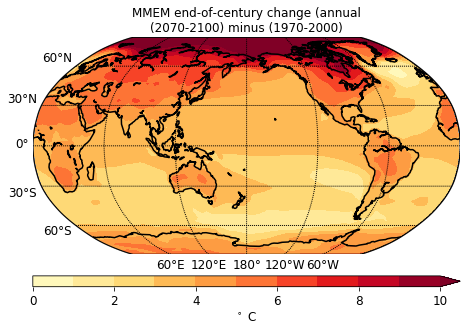

In [12]:
fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
#contour_levels = numpy.arange(-1.5,1.6,0.25)
contour_levels = numpy.arange(0,11,1)

tas_map = map.contourf(xi,yi,tas_anoms_mmem,cmap='YlOrRd', levels=contour_levels, extend='max')
#tas_signif = map.contourf(xi,yi,tas_pvals_list[model_index], colors='none', levels=[0.0,0.01,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$^\circ$ C', fontsize=12)
ax.set_title('MMEM end-of-century change ('+season+'\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

fig.tight_layout()

# Plot end-of-century anomalies for individual models (RCP8.5 minus historical)
* Choose the __`model_index`__ and plot
* Default: 2 (GFDL-ESM4)

In [13]:
model_index = 2

* Plot

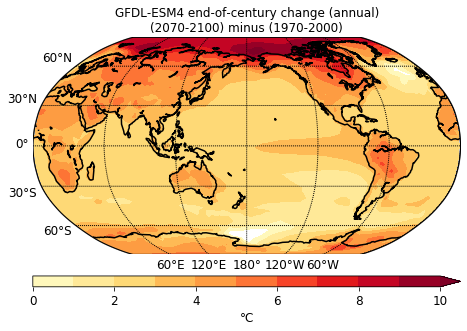

In [14]:
fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(0,11,1)
tas_map = map.contourf(xi,yi,tas_anoms_list[model_index],cmap='YlOrRd', levels=contour_levels, extend='max')
cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(degree_sign+'C', fontsize=12)
ax.set_title(model_names_cmip6[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

fig.tight_layout()
#mp.savefig('plots/tas_anoms_'+model_names[model_index]+'_'+season+'.pdf', transparent=True, bbox_inches='tight')

# Plot end-of-century minus historical with stippling where the grid points pass a statistical significance test

* The test used here is a Student's *t* test for difference in means between the historical and end-of-century months.  It is calculated in the __Calculate climatologies...__ boxes above.
* By default keeps the same model as above (to change, uncomment the __`model_index=`__ line and choose model)
* The default significance level is 95% (set __`sig_level=`__ to be 1 minus significance level)

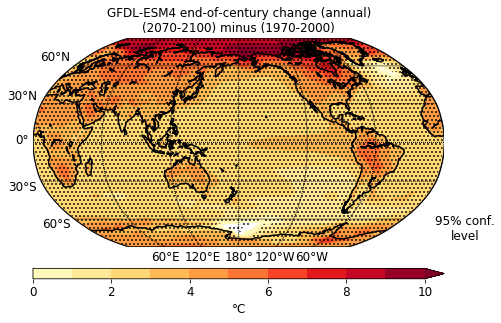

In [15]:
sig_level = 5 # 95% confidence means sig_level = 5

fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(0,11,1)

tas_map = map.contourf(xi,yi,tas_anoms_list[model_index],cmap='YlOrRd', levels=contour_levels, extend='max')
tas_signif = map.contourf(xi,yi,tas_pvals_list[model_index], colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(degree_sign+'C', fontsize=12)
ax.set_title(model_names_cmip6[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)

fig.tight_layout()
#mp.savefig('plots/tas_anoms_'+model_names[model_index]+'_'+season+'_signif_stippling.pdf', transparent=True, bbox_inches='tight')

# Temperature change zoomed in
* Change __lat__/__lon__, and __sig_level__
* By default keeps the same model as above (to change, uncomment the __`model_index=`__ line and choose model)

In [16]:
lat_lo = 10
lat_hi = 65
lon_lo = 230
lon_hi = 290

# model_index = 8

sig_level = 5 # 95th confidence means sig_level = 5

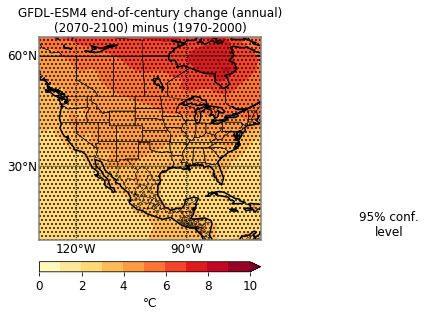

In [17]:
fig = mp.figure(figsize=(7,4.5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',llcrnrlat=lat_lo,urcrnrlat=lat_hi,llcrnrlon=lon_lo,urcrnrlon=lon_hi,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,30.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
map.drawstates()
map.drawcountries()
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(0,11,1)

tas_map = map.contourf(xi,yi,tas_anoms_list[model_index],cmap='YlOrRd', levels=contour_levels, extend='max')
tas_signif = map.contourf(xi,yi,tas_pvals_list[model_index], colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(degree_sign+'C', fontsize=12)
ax.set_title(model_names_cmip6[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)

fig.tight_layout()
#mp.savefig('plots/tas_anoms_'+model_names[model_index]+'_'+season+'_signif_stippling_ZOOM.pdf', transparent=True, bbox_inches='tight')

# Comparion with CMIP5 model version
* using the model index above, we will now create side-by-side plots to look at differences of the CMIP5 and CMIP6 forecasts 

### First, we load in the CMIP5 data as we did in previous cells

In [18]:
tas_hist_months_list_cmip5 = []  
tas_rcp_months_list_cmip5 = []


for i in range(model_names_cmip5.size):
    
    print("opening model", model_names_cmip5[i])

    # OPEN HISTORICAL PERIOD pr DATA
    modelname = model_names_cmip5[i]
    ncfile = netCDF4.Dataset(file_root+'cmip5/'+tas_hist_cmip5[i], 'r', format='NETCDF4')
    tas_hist_data = ncfile.variables['tas'][:,:,:]-273.15 # K to degrees C
    time_variable = ncfile.variables['time']
    date_start = netCDF4.date2num(hist_start, time_variable.units, time_variable.calendar)
    date_end = netCDF4.date2num(hist_end, time_variable.units, time_variable.calendar)
    model_time = time_variable[:]
    
    time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)
        
    time_indices = numpy.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) for t in time_variable_converted])
    tas_hist_data_seas = tas_hist_data[time_indices,:,:]
    
    # Add the data from the i-th model to the list
    tas_hist_months_list_cmip5.append(tas_hist_data_seas[:,:,:])
    
    modelname = model_names_cmip5[i]
    ncfile = netCDF4.Dataset(file_root+'cmip5/' + tas_rcp_cmip5[i], 'r', format='NETCDF4')
    tas_rcp_data = ncfile.variables['tas'][:,:,:]-273.15 # K to degrees C
    time_variable = ncfile.variables['time']
    date_start = netCDF4.date2num(rcp_start, time_variable.units, time_variable.calendar)
    date_end = netCDF4.date2num(rcp_end, time_variable.units, time_variable.calendar)
    model_time = time_variable[:]
    
    time_variable_converted = netCDF4.num2date(time_variable[:], time_variable.units, time_variable.calendar)
         
    time_indices = numpy.array([(t.month in months)&(t.year in range(rcp_start.year, rcp_end.year+1)) for t in time_variable_converted])
    tas_rcp_data_seas = tas_rcp_data[time_indices,:,:]

    # Add the data from the i-th model to the list
    tas_rcp_months_list_cmip5.append(tas_rcp_data_seas[:,:,:])
    
    
    
    
# create empty lists to store the climatologies, anomalies, 
# and p-values for a statistical significance test

tas_hist_clim_list_cmip5 = []
tas_rcp_clim_list_cmip5 = []
tas_anoms_list_cmip5 = []
tas_pvals_list_cmip5 = []

# calculate the fields listed above for each model, 
#  and "append" the results to the existing lists
# uncomment the print line below to see how the size of the lists change with i
for i in range(model_names_cmip5.size):
    #print(tas_hist_months_list[i].shape, tas_rcp_months_list[i].shape)
    tas_hist_clim_list_cmip5.append(numpy.mean(tas_hist_months_list_cmip5[i], axis=0)) # calculate time-mean (0-th axis=time)
    tas_rcp_clim_list_cmip5.append(numpy.mean(tas_rcp_months_list_cmip5[i], axis=0))
    tas_anoms_list_cmip5.append(tas_rcp_clim_list_cmip5[-1] - tas_hist_clim_list_cmip5[-1])
    tas_pvals_list_cmip5.append(scipy.stats.ttest_ind(tas_hist_months_list_cmip5[i], tas_rcp_months_list_cmip5[i], axis=0)[1])

# The last line calculate the t-test to determine whether 
#  the precipitation distribution under historical forcings
#  is significantly different from that under global warming conditions
# To know more, google "scipy.stats.ttest_ind" or "student's t-test"

opening model bcc-csm1-1-m
opening model CESM1-CAM5
opening model GFDL-CM3
opening model GISS-E2-H
opening model IPSL-CM5A-LR
opening model MIROC-ESM
opening model MPI-ESM-LR
opening model MRI-CGCM3


## Create plots to compare CMIP5 and CMIP6 on global scale


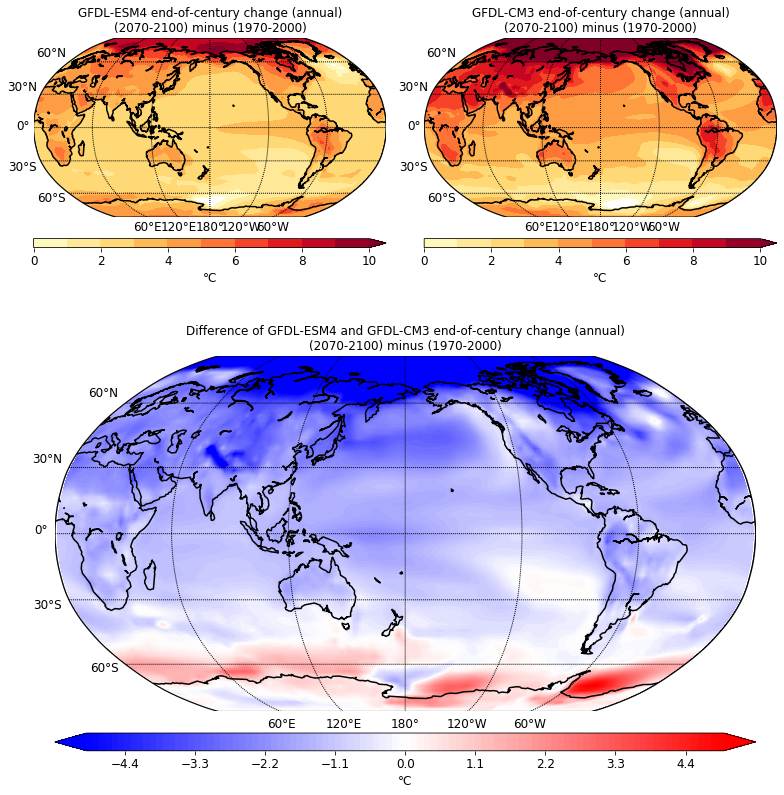

In [19]:
fig = mp.figure(figsize=(11,12))

ax = fig.add_subplot(221)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(0,11,1)
tas_map = map.contourf(xi,yi,tas_anoms_list[model_index],cmap='YlOrRd', levels=contour_levels, extend='max')
cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(degree_sign+'C', fontsize=12)
ax.set_title(model_names_cmip6[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)

ax = fig.add_subplot(222)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(0,11,1)
tas_map = map.contourf(xi,yi,tas_anoms_list_cmip5[model_index],cmap='YlOrRd', levels=contour_levels, extend='max')
cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(degree_sign+'C', fontsize=12)
ax.set_title(model_names_cmip5[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)


ax = fig.add_subplot(212)
map = basemap.Basemap(projection='robin', lon_0=-180., resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(-5,5.1,0.1)
tas_map = map.contourf(xi,yi,tas_anoms_list[model_index]-tas_anoms_list_cmip5[model_index],cmap='bwr', levels=contour_levels, extend='both')
cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(degree_sign+'C', fontsize=12)
ax.set_title('Difference of ' + model_names_cmip6[model_index] + ' and ' + model_names_cmip5[model_index]+ ' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)







fig.tight_layout()
#mp.savefig('plots/tas_anoms_'+model_names[model_index]+'_'+season+'.pdf', transparent=True, bbox_inches='tight')

## Create plots to compare CMIP5 and CMIP6 versions for a particular region
*  a region was already chosen above, print the lat-lon boundaries to check them. You can use the ones that set above, or if more convenient, reset them in the cell below to specifiy a new region

In [20]:
print ('lat_lo, lat_hi, lon_lo, lon_hi = ',lat_lo, lat_hi, lon_lo, lon_hi)

In [22]:
#uncomment these lines if you want to set your region here instead of the values you used above
#lat_lo = 10
#lat_hi = 65
#lon_lo = 230
#lon_hi = 290

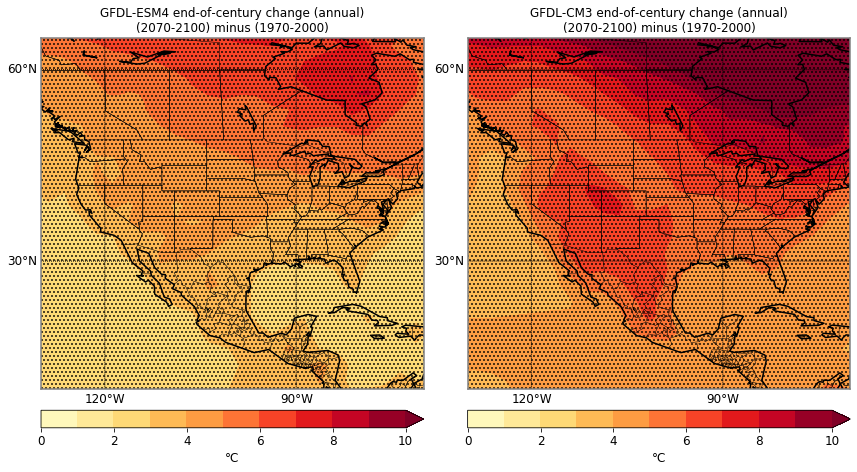

In [21]:
fig = mp.figure(figsize=(12,9))

ax = fig.add_subplot(121)
map = basemap.Basemap(projection='cyl',llcrnrlat=lat_lo,urcrnrlat=lat_hi,llcrnrlon=lon_lo,urcrnrlon=lon_hi,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,30.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
map.drawstates()
map.drawcountries()
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(0,11,1)


tas_map = map.contourf(xi,yi,tas_anoms_list[model_index],cmap='YlOrRd', levels=contour_levels, extend='max')


tas_signif = map.contourf(xi,yi,tas_pvals_list[model_index], colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(degree_sign+'C', fontsize=12)
ax.set_title(model_names_cmip6[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
#ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)



ax = fig.add_subplot(122)
map = basemap.Basemap(projection='cyl',llcrnrlat=lat_lo,urcrnrlat=lat_hi,llcrnrlon=lon_lo,urcrnrlon=lon_hi,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = numpy.arange(-60.,61.,30.)
meridians = numpy.arange(0.,361.,30.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
map.drawstates()
map.drawcountries()
lons,lats = numpy.meshgrid(model_lon, model_lat)
xi,yi = map(lons, lats)
contour_levels = numpy.arange(0,11,1)


tas_map = map.contourf(xi,yi,tas_anoms_list_cmip5[model_index],cmap='YlOrRd', levels=contour_levels, extend='max')


tas_signif = map.contourf(xi,yi,tas_pvals_list_cmip5[model_index], colors='none', levels=[0.0,sig_level/100.,1.0], hatches=['...',None], extend='lower')

cbar = map.colorbar(tas_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(degree_sign+'C', fontsize=12)
ax.set_title(model_names_cmip5[model_index]+' end-of-century change ('+season+')\n' + '('+str(rcp_start.year)+'-'+str(rcp_end.year)+') minus ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=12)
#ax.text(s=str(100-sig_level)+'% conf.\nlevel', x=0.93, y=0.25, ha='center', va='bottom', transform=fig.transFigure, fontsize=12)



fig.tight_layout()
#mp.savefig('plots/tas_anoms_'+model_names[model_index]+'_'+season+'_signif_stippling_ZOOM.pdf', transparent=True, bbox_inches='tight')